<!-- <img src="./assets/imgs/DinoCC.png" width="700"> -->
## Concise DINO Code:
___

<br>
I've streamlined the DinoV2 code repository and integrated a wrapper for clarity. This allows you to easily understand the core mechanics of how the model functions, without being sidetracked by the complexities of distributed computing and other extraneous add-ons that obscure the model's primary operations.
<br><br>

This code covers:
```
    1. Dataloading an Augmentation
    2. Dino Model
    3. Training Methods
    4. Model Demo
```
<br><br>


<div style="position: relative; width: 700px;">
    <img src="./assets/imgs/DinoCC.png" style="position: absolute; bottom: -10px; right: 0px; width: 260px;">
</div>



<div style="position: relative; width: 800px;">
    <img src="./assets/imgs/DinoCC2.png" style="position: absolute; bottom: -10px; right: 0px; width: 260px;">
</div>

#### 1. Dataloading an Augmentation
___

1. **Imports**: 
    - Standard libraries for argument parsing, file I/O, randomness, and system operations are imported.
    - Libraries specific to image processing, plotting, and deep learning (`matplotlib`, `numpy`, `torch`, `PIL`, and `torchvision`) are imported.
    - Custom modules are added to the system path and then imported.

2. **Seeding**:
    - The `seed_everything` function is used to seed different random processes to ensure reproducibility in the code. The function sets seeds for Python's `random`, `numpy`, and `torch`.

3. **ImageNetDataset Class**:
    - This is a custom PyTorch dataset class for loading batches of images from ImageNet.
    - The constructor (`__init__`) scans a directory for data batch files and calculates the total number of images across all batches.
    - The `__len__` method returns the total number of images.
    - The `__getitem__` method reads an image from a specific batch and index, reshapes it, and then applies the specified transformation (if any).
    - The `format_image` static method reshapes a flattened image array into its original shape.

4. **DataAugmentationDINO Class**:
    - This class is for data augmentation, specifically for the DINO (DIstillation of NOt labeled data) technique.
    - The constructor (`__init__`) sets up various augmentation pipelines using `torchvision.transforms`. These include:
        - Flipping, color jittering, normalization, Gaussian blur, solarization, and random resized cropping.
        - Separate transformation pipelines are defined for two global crops and multiple local crops.
    - The `__call__` method applies these transformations to an input image and returns a list of augmented images.

5. **Data Loading and Augmentation**:
    - The random seeds are set using the `seed_everything` function.
    - The `DataAugmentationDINO` class is instantiated with specific parameters.
    - The `ImageNetDataset` class is instantiated with a directory path and the above augmentation pipeline.
    - The PyTorch `DataLoader` is set up to load batches of images from the dataset.
    - A loop is started to iterate through the data loader, but it breaks immediately after the first iteration (likely a placeholder for future code).


In [3]:
import argparse
import glob
import os
import pickle
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

sys.path.append("./../dino")
sys.path.append("./../src")

import utils
from constants import COLORS
from plotting.vis_tools import visualize_attention


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
class ImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.batches = glob.glob(f'{root_dir}/*_data_batch_*')
        self.total_images = 0
        self.cumulative_sizes = []
        print(self.batches)
        for file_path in self.batches:
            with open(file_path, 'rb') as f:
                batch_data = pickle.load(f)
            self.total_images += len(batch_data['data'])
            self.cumulative_sizes.append(self.total_images)
        
        self.transform = transform

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        for i, size in enumerate(self.cumulative_sizes):
            if idx < size:
                batch_idx = i
                break

        file_path = self.batches[batch_idx]
        with open(file_path, 'rb') as f:
            batch_data = pickle.load(f)

        img_idx = idx if batch_idx == 0 else idx - self.cumulative_sizes[batch_idx - 1]
        im_flat = batch_data['data'][img_idx]
        im = self.format_image(im_flat).astype(np.uint8)  # Convert to uint8 for PIL
        im = Image.fromarray(im)
        
        return self.transform(im) if self.transform else im

    @staticmethod
    def format_image(im_flat):
        im = np.zeros((64, 64, 3), dtype=im_flat.dtype)
        for i in range(3):  # Red, Green, Blue channels
            im[:,:,i] = np.reshape(im_flat[i*4096:(i+1)*4096], (64, 64))
        return im

    
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, image_size=64):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(int(96/(244/image_size)), scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return transforms.ToTensor()(image), crops

# Call the above function to seed everything
seed_everything()
local_crops_number = 4
batch_size = 32

data_transform = DataAugmentationDINO(
    global_crops_scale=(0.4, 1.0), 
    local_crops_scale=(0.05, 0.4), 
    local_crops_number=local_crops_number
)

root_dir = "./../data/imageNet/Imagenet64_train"
train_dataset = ImageNetDataset(root_dir, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for i, (unaug_img, aug_inputs) in enumerate(train_loader):
    break

C:\Users\cmorris310\AppData\Local\Temp\ipykernel_21360\391072420.py:92: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.RandomResizedCrop(image_size, scale=global_crops_scale, interpolation=Image.BICUBIC),
C:\Users\cmorris310\AppData\Local\Temp\ipykernel_21360\391072420.py:99: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.RandomResizedCrop(image_size, scale=global_crops_scale, interpolation=Image.BICUBIC),
C:\Users\cmorris310\AppData\Local\Temp\ipykernel_21360\391072420.py:108: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.RandomResizedCrop(int(96/(244/image_size)), scale=local_crops_scale, interpolation=Image.BICUBIC),


['./../data/imageNet/Imagenet64_train\\train_data_batch_1', './../data/imageNet/Imagenet64_train\\train_data_batch_10', './../data/imageNet/Imagenet64_train\\train_data_batch_2', './../data/imageNet/Imagenet64_train\\train_data_batch_3', './../data/imageNet/Imagenet64_train\\train_data_batch_4', './../data/imageNet/Imagenet64_train\\train_data_batch_5', './../data/imageNet/Imagenet64_train\\train_data_batch_6', './../data/imageNet/Imagenet64_train\\train_data_batch_7', './../data/imageNet/Imagenet64_train\\train_data_batch_8', './../data/imageNet/Imagenet64_train\\train_data_batch_9']


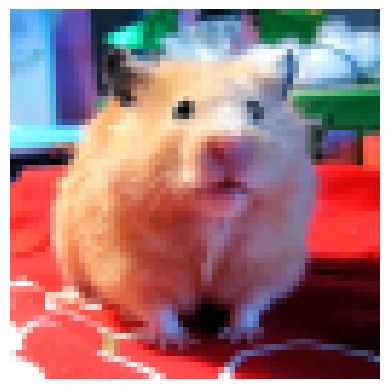

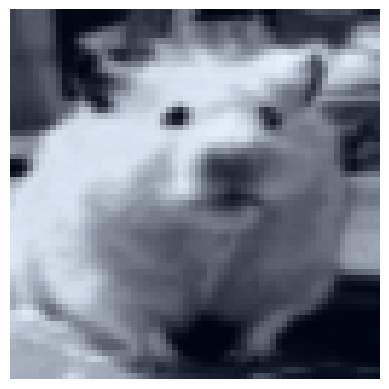

torch.Size([3, 64, 64])


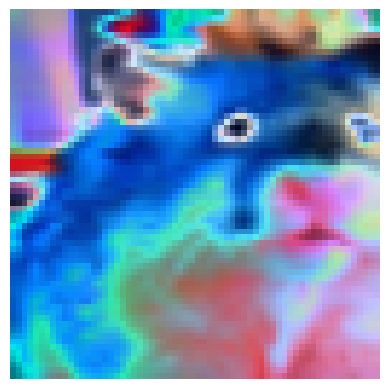

torch.Size([3, 64, 64])


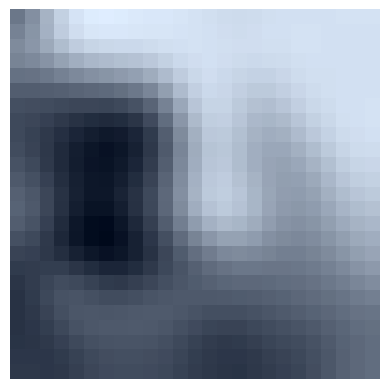

torch.Size([3, 25, 25])


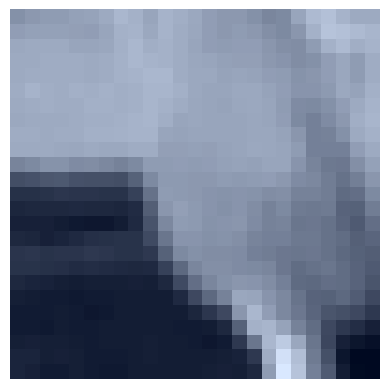

torch.Size([3, 25, 25])


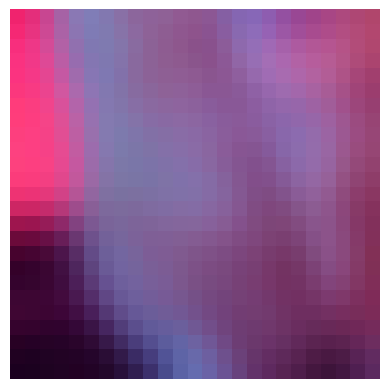

torch.Size([3, 25, 25])


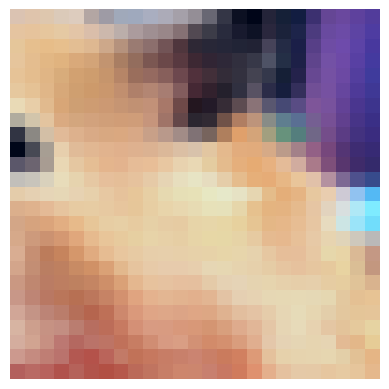

torch.Size([3, 25, 25])


In [6]:
def simple_imshow_tensor(im):
    # Assuming `img` is your image tensor with shape [3, 64, 64]
    im = im.permute(1, 2, 0)  # Change from CxHxW to HxWxC
    im = (im-im.min())/(im.max()-im.min())
    # If your image values are in [0, 255], you can normalize them to [0, 1]
    # im = im / 255.0
    plt.imshow(im)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()
    
batch_idx = 1
for im_idx in range(local_crops_number+2):
    if im_idx == 0:
        im = unaug_img[batch_idx]
        simple_imshow_tensor(im)
    im = aug_inputs[im_idx][batch_idx]
    simple_imshow_tensor(im)
    print(im.shape)

#### 2. Dino Model
___

1. **DINOLoss Class**:
    - **Purpose**: Computes the DINO loss, which measures the similarity between the outputs of a student network and a teacher network.
    - **Initialization**:
        - Sets hyperparameters like temperature scaling for the student and teacher networks, momentum for updating the center, etc.
        - Initializes a buffer for the center (used for centering the teacher's output).
        - Creates a temperature schedule for the teacher's output.
    - **forward method**: 
        - Computes the DINO loss and updates the center of the teacher's output.
    - **compute_dino_loss method**:
        - The core method that computes the DINO loss. The outputs of the student and teacher networks are temperature-scaled and then compared.
        - The loss is calculated based on the similarity between the student's output for all views except one and the teacher's output for that view.
    - **update_center method**:
        - Updates the center of the teacher's output with a running average.

2. **DINO Class**:
    - **Purpose**: Defines the DINO model comprising both a student network and a teacher network. The teacher is a non-trainable copy of the student.
    - **Initialization**:
        - Defines and initializes both student and teacher networks based on a given model type (like "tiny", "small", etc.).
        - Appends a DINOHead to both networks, which is likely a custom neural network head for the DINO task (its definition isn't provided in the code).
        - Initializes the teacher network with the student's weights and freezes its gradients, making it non-trainable.
    - **forward method**:
        - Performs a forward pass through either the student or teacher network based on the `is_teacher` flag.
        - The output is reshaped and passed through the DINO head.
    - **get_last_selfattention method**:
        - This method retrieves the last self-attention weights from the student network. It can be useful for visualization or analysis.


In [8]:
import torch
import torch.nn as nn
from torch import nn, einsum
from torch.optim import AdamW
import torch.nn.functional as F
from einops import rearrange, repeat
from vision_transformer import DINOHead, vit_small, vit_tiny, vit_base, vit_tinyer, vit_tiniest

class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        dino_loss = self.compute_dino_loss(student_output, teacher_output, epoch)
        # Combine the DINO loss and the energy loss
        total_loss = dino_loss
        self.update_center(teacher_output)
        return total_loss

    def compute_dino_loss(self, student_output, teacher_output, epoch):
        self.center = self.center.to(student_output.device)
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)
        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)
        
class DINO(nn.Module):
    def __init__(self, out_dim=65536, use_bn=False, model_type="tiny"):
        super().__init__()
        model_map = {'tiny':vit_tiny(), 'small':vit_small(), 'base':vit_base(),
                     'vit_tinyer':vit_tinyer()
                    }
        # Student network
        self.student = model_map[model_type]
        embed_dim = self.student.embed_dim
        
        self.student = nn.Sequential(
            self.student,
            DINOHead(embed_dim, out_dim, use_bn)
        )
        # Teacher network
        self.teacher = model_map[model_type]
        self.teacher = nn.Sequential(
            self.teacher,
            DINOHead(embed_dim, out_dim, use_bn)
        )
        # Initialize teacher and student with same weights
        self.teacher.load_state_dict(self.student.state_dict())
        # Turn off gradients for teacher network
        for param in self.teacher.parameters():
            param.requires_grad = False

    def forward(self, x, is_teacher=False):
        # Forward pass through Perceiver
        batch_size = x.shape[0]
        x = self.student[0](x) if not is_teacher else self.teacher[0](x)
        # combine latents
        x = x.view(batch_size, 1, -1)
        x = self.student[1](x) if not is_teacher else self.teacher[1](x)
        return x

    def get_last_selfattention(self, x):
        return self.student[0].get_last_selfattention(x)

#### 3. Training Methods:
___

In [9]:
# Only one instance of DINO class
dino_instance = DINO(model_type=model_type, out_dim=dino_out_dim, use_bn=False).to(device)
# Optimizer initialization
optimizer = AdamW(dino_instance.student.parameters(), lr=lr, weight_decay=0.01)
# Instantiate the EBM DINO loss
dino_loss = DINOLoss(out_dim=dino_out_dim, ncrops=(2+local_crops_number), 
                            warmup_teacher_temp=warmup_teacher_temp, 
                            teacher_temp=teacher_temp, 
                            warmup_teacher_temp_epochs=warmup_teacher_temp_epochs, 
                            nepochs=epochs)

In [10]:
out_name = F"model_DINO_{model_type}_{name}"
path2models = os.path.join(model_dir, model_dir)
if not os.path.exists(path2models):
    os.makedirs(path2models)

In [11]:
# Constants
clip_grad = 3
freeze_last_layer = 1
momentum = 0.996  # Or whatever value you've chosen
save_interval = 50
# Training loop

for epoch in range(total_epochs):
    for i, (_, images) in enumerate(train_loader):
        student_outputs, teacher_outputs = [], []
        # Process images through student and teacher networks
        for j, image in enumerate(images):
            image = image.to(device)
            student_output = dino_instance(image)
            student_outputs.append(student_output)
            if j < 2:
                with torch.no_grad():
                    teacher_output = dino_instance.forward(image, is_teacher=True)
                    teacher_outputs.append(teacher_output)

        # Compute EBM DINO loss
        student_outputs_tensor = torch.stack(student_outputs)
        teacher_outputs_tensor = torch.stack(teacher_outputs)
        loss = dino_loss(student_output=student_outputs_tensor, teacher_output=teacher_outputs_tensor, epoch=epoch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        param_norms = utils.clip_gradients(dino_instance.student, clip_grad)
        utils.cancel_gradients_last_layer(epoch, dino_instance.student, freeze_last_layer)
        optimizer.step()

        # Model checkpointing
        if i % save_interval == 0 and i != 0:
            model_suffix = f'model_e{str(epoch).zfill(4)}_i{str(i).zfill(6)}.pth'
            torch.save(dino_instance.student.state_dict(), f'{path2models}/student_{model_suffix}')
            torch.save(dino_instance.teacher.state_dict(), f'{path2models}/teacher_{model_suffix}')
            print([i, loss.item()])  # loss.item() to get a scalar value

        # Update teacher parameters (exponential moving average of student parameters)
        with torch.no_grad():
            for param_student, param_teacher in zip(dino_instance.student.parameters(), dino_instance.teacher.parameters()):
                param_teacher.data.mul_(momentum).add_((1 - momentum) * param_student.detach().data)

    # Save models at the end of the epoch
    model_suffix = f'model_e-{str(epoch).zfill(4)}.pth'
    torch.save(dino_instance.student.state_dict(), f'{path2models}/student_{model_suffix}')
    torch.save(dino_instance.teacher.state_dict(), f'{path2models}/teacher_{model_suffix}')


KeyboardInterrupt



#### 4. Model Demo:
___

In [12]:
name = 'run_x'

epochs = 10
model_type = "vit_tinyer"
dino_out_dim = 65536
total_epochs = 1
warmup_teacher_temp = 0.02
teacher_temp = 0.04
warmup_teacher_temp_epochs = 5
lr = 0.0005
device = 'cpu'
model_dir = './models'

model_name = 'student_model_e0000_i002450.pth'
path2model = './models/models/{}'.format(model_name)
# Load the student model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Using GPU if available, else CPU
# student_model_path = f'{path2model}/student_model_e-{epoch_w}.pth'  # replace with your path
student_model_path = path2model  # replace with your path
student_state_dict = torch.load(student_model_path)
dino_instance = DINO(model_type=model_type, out_dim=dino_out_dim).to(device)  # initialize the model architecture
dino_instance.student.load_state_dict(student_state_dict)  # load the saved weights


<All keys matched successfully>

Number of heads: 3
Batch Size: 32


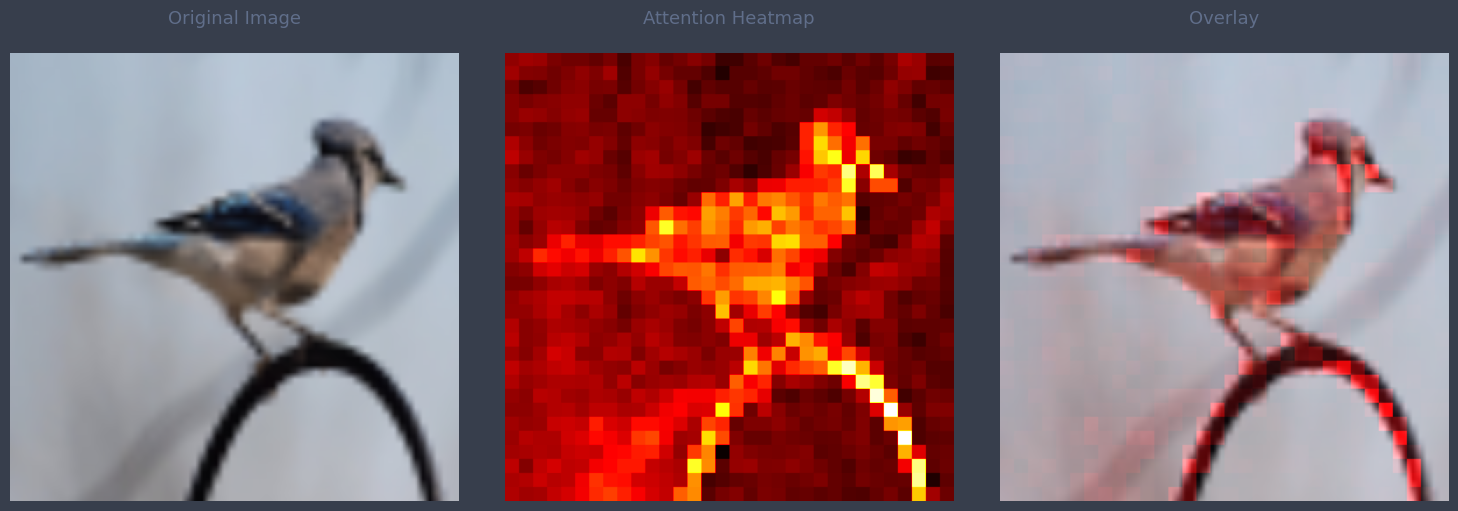

In [19]:
import torch.nn.functional as F
# Assuming `images` is your tensor of shape torch.Size([32, 3, 64, 64])
upscaled_images = F.interpolate(unaug_img, size=(256, 256), mode='bilinear', align_corners=True)


visualize_attention(upscaled_images, dino_instance, device, patch_size=8, 
                    output_dir='./outputs', head_idx=2, image_idx=2)

Number of heads: 3
Batch Size: 32


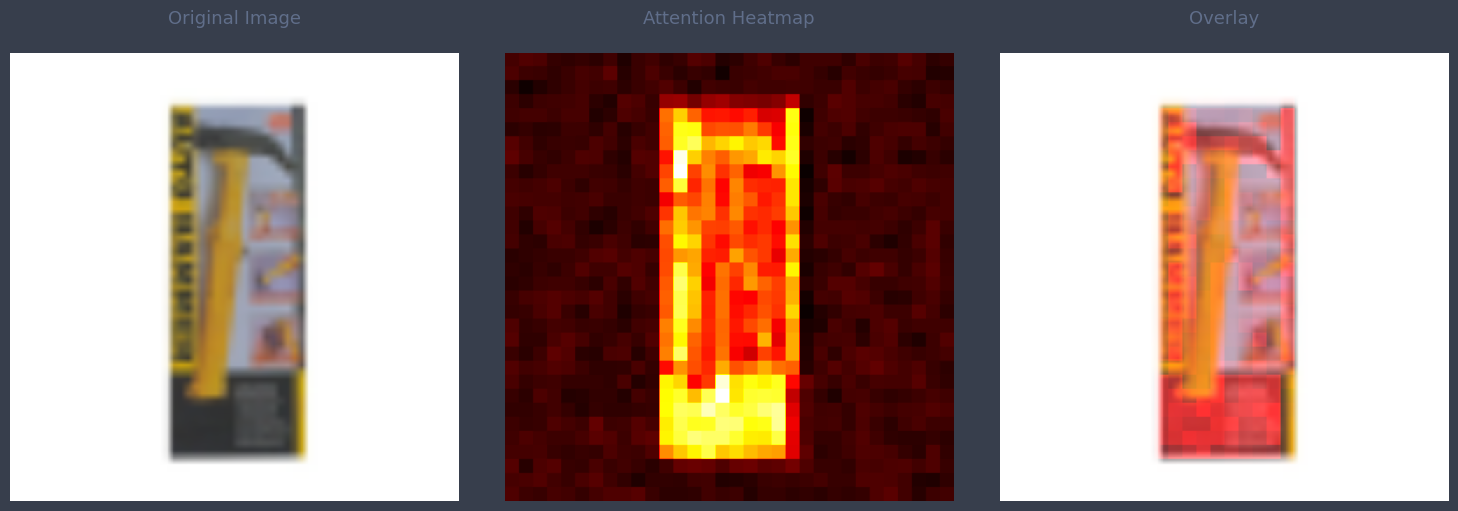

In [34]:
visualize_attention(upscaled_images, dino_instance, device, patch_size=8, 
                    output_dir='./outputs', head_idx=2, image_idx=12)

Number of heads: 3
Batch Size: 32


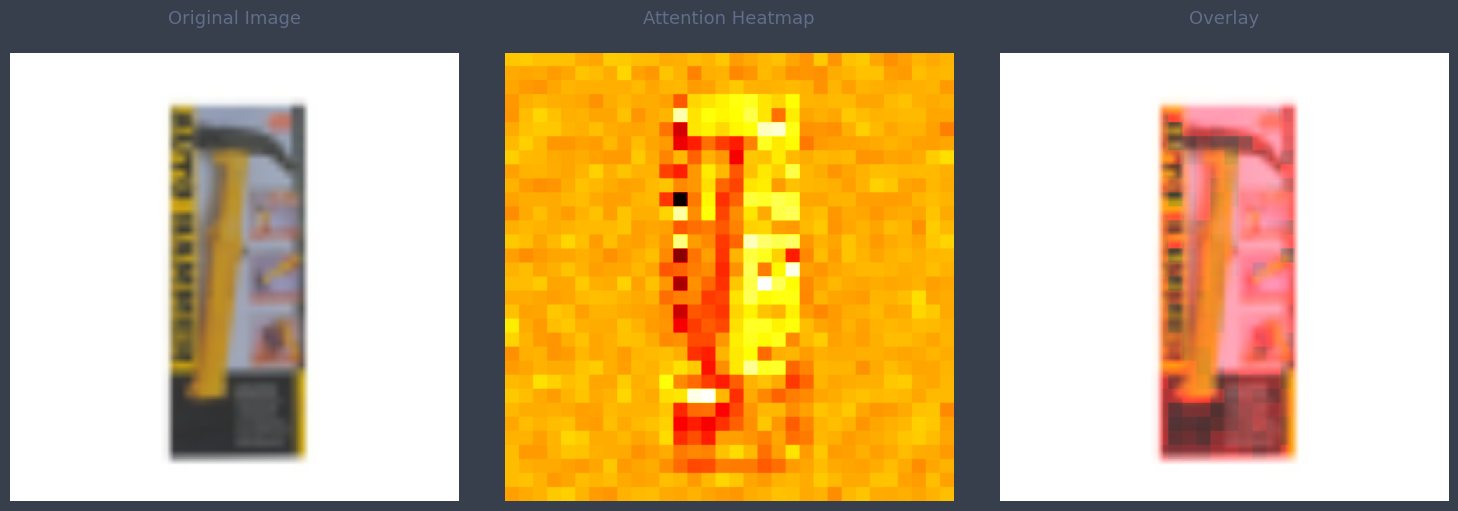

In [35]:
visualize_attention(upscaled_images, dino_instance, device, patch_size=8, 
                    output_dir='./outputs', head_idx=1, image_idx=12)